<a href="https://colab.research.google.com/github/YirenShen-07/Yiren-590Assignment7/blob/main/Assignment7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #07
### Explainable Deep Learning in Predicting High-Value Retail Transactions
The objective of the research is twofold: to establish that many properties of retail transactions support or inhibit the ability to predict high-value transactions with a deep learning model and how explainable AI techniques could reinforce that. Open to scrutiny, this research investigates whether the attention weights the model assigns to the feature of 'age' are significantly different from those assigned to other features such as gender, product category, month, and day of the week. The **Integrated Gradients** feature attribution method and the t-test to compare the relative importance of various features show that the model gives significantly different weightings to 'age' than to gender and product category. This experiment illustrates how these reasonable and interpretable deep learning techniques quantify the contribution of a number of features-a major step towards understanding model decisions in the retail sphere.

### Yiren Shen

#### Include the button below. Change the link to the location in your github repository:https://github.com/YirenShen-07/Yiren-590Assignment7/blob/main/Assignment7.ipynb

## DO:
Develop a hypothesis and design a study using explainable deep learning methods to test your hypothesis. You can use any deep learning method discussed during the lecture: concept activation vectors, feature visualization, saliency maps, integrated gradients, or occlusion methods.



Hypothesis must be in the form of a null/alternative hypothesis.



Share your result as a visual report. This report can be in the form of a Google Colab, webpage, blog, or PDF and should contain the H0/H1 hypothesis, a brief explanation of the approach, the visualizations and/or explanations, and a summary of your findings. If Google Colab is not your medium of choice, please include source code as a link in your report.



Note: You will NOT be graded on whether or not your null hypothesis was rejected, only on whether your experiments appropriately tested your hypothesis.

(Here, I would use TCAV and statistical testing, see code demo in GitHub!)



## Rubric:
* Appropriate null and alternative hypotheses are formulated
* Appropriate experiment(s) are designed to test the null hypothesis
* Report includes a brief explanation of approach
* Report includes source code (as a link or in the report itself)
* Visualizations are clear, follow best practices, and has a clear caption/explanation
* Visualizations support the conclusions
* Report includes summary of findings
* Code implementing the explanation techniques is clear and well documented
* Visualizations are clear, follow best practices, and has a clear caption/explanation in the notebook markdown

# Hypotheses
**Null Hypothesis (H0):** The deep neural network's attentional weighting of the **age** feature is not significantly different from the other features in predicting high-value transactions.

**Alternative Hypothesis (H1):** The deep neural network's attentional weights on the **age** feature are significantly different from the other features in predicting high-value deals.

In [ ]:
import csv
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
df="/content/drive/MyDrive/RetailSales.csv"
df=pd.read_csv(df)
df

,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100
...,...,...,...,...,...,...,...,...,...
995,996,2023-05-16,CUST996,Male,62,Clothing,1,50,50
996,997,2023-11-17,CUST997,Male,52,Beauty,3,30,90
997,998,2023-10-29,CUST998,Female,23,Beauty,4,25,100
998,999,2023-12-05,CUST999,Female,36,Electronics,3,50,150


**Dataset:** The dataset contains retail transaction records with features like gender, age, product category, month, and day of the week. The target variable is whether the transaction is high-value (i.e., total amount > 500).

In [ ]:
!pip install tensorflow pandas numpy scikit-learn matplotlib seaborn

# Data Preprocessing

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import io

**Pre-processing of retail sales data:** Convert the raw data into a format acceptable to the model. The main steps include date extraction, category coding, target variable creation, feature selection, and normalization to ensure that the data is suitable for use in deep learning model training and interpretive analysis. Ultimately, the normalized features, target variables, and feature column names are returned, ready for subsequent model construction and analysis.

In [ ]:
# Data Preprocessing Function
def preprocess_data(df):
    # Convert Date to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek

    # Label encode categorical variables
    le_gender = LabelEncoder()
    le_category = LabelEncoder()
    df['Gender'] = le_gender.fit_transform(df['Gender'])
    df['Product_Category'] = le_category.fit_transform(df['Product Category'])

    # Create target variable
    df['HighValue'] = (df['Total Amount'] > 500).astype(int)

    # Select features for model
    feature_columns = ['Gender', 'Age', 'Product_Category', 'Month', 'DayOfWeek']
    X = df[feature_columns].values
    y = df['HighValue'].values

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )

    return X_train, X_test, y_train, y_test, feature_columns

# Load dataset and preprocess data
X_train, X_test, y_train, y_test, feature_columns = preprocess_data(df)

# Print column names before processing
print("\nAvailable columns in dataset:")
print(df.columns.tolist())



Available columns in dataset:
['Transaction ID', 'Date', 'Customer ID', 'Gender', 'Age', 'Product Category', 'Quantity', 'Price per Unit', 'Total Amount', 'Month', 'DayOfWeek', 'Product_Category', 'HighValue']


The output shows the results of the data preprocessing, including the column names of the original dataset, the five features selected for use in the model, and the shapes of the processed features and target variables. This indicates that the data has been successfully converted into a format acceptable to the model and is ready for model training and analysis.

# Integrated Gradients

By calculating the integrated gradient, the contribution of each feature can be obtained and compared with the “age” feature to help test the original hypothesis (H0) or alternative hypothesis (H1).

The importance of the features provided by the integrated gradient is used as input, and combined with statistical tests, you can determine which features have significantly different weights than the “age” feature, and conclude whether to reject the original hypothesis.

## Integrated Gradients Implementation

In [ ]:
# Step1: Interpolate Inputs
def interpolate_inputs(baseline, inputs, m_steps):
    # Convert inputs to float32
    baseline = tf.cast(baseline, tf.float32)
    inputs = tf.cast(inputs, tf.float32)

    alphas = tf.linspace(0.0, 1.0, m_steps+1)
    alphas_x = tf.cast(alphas[:, tf.newaxis], tf.float32)

    baseline_x = tf.expand_dims(baseline, axis=0)
    input_x = tf.expand_dims(inputs, axis=0)

    delta = input_x - baseline_x
    interpolated = baseline_x + alphas_x * delta

    return interpolated

# Step2: Compute Gradients
def compute_gradients(model, inputs):
    with tf.GradientTape() as tape:
        inputs = tf.cast(inputs, tf.float32)
        tape.watch(inputs)
        outputs = model(inputs)
    return tape.gradient(outputs, inputs)

# Step3: Integrated Gradients Calculation
def integrated_gradients(model, baseline, inputs, m_steps=50):
    interpolated = interpolate_inputs(baseline, inputs, m_steps)
    grads = compute_gradients(model, interpolated)

    # Ensure consistent data types
    grads = tf.cast(grads, tf.float32)
    baseline = tf.cast(baseline, tf.float32)
    inputs = tf.cast(inputs, tf.float32)

    integrated_grads = (inputs - baseline) * tf.reduce_mean(grads, axis=0)
    return integrated_grads

**Step1 Purpose:** To generate a number of interpolated samples between baseline and actual inputs.

**Step2 Purpose:** To calculate the gradient (sensitivity) of the model's output to the input on each interpolated sample.

**Step3 Purpose:** To measure the contribution of input features to the model output by interpolating the average gradient of the samples.

I use **Integrated Gradients** to gain insights into the features (e.g., gender, age, product category) that exert a substantial influence on the model's decision, indicating how each feature contributes to the prediction outcome. It provides clear insight into the importance of the features while keeping an eye on whether or not the behavior of the model is compliant with business expectations regarding retail analytics.



## Feature Importance Analysis

In [ ]:
def analyze_feature_importance(model, X_test, feature_names):
    # Convert to float32
    X_test = tf.cast(X_test, tf.float32)
    baseline = tf.cast(tf.reduce_mean(X_test, axis=0), tf.float32)
    #  Calculate feature attribution
    attributions = []
    for x in X_test:
        ig = integrated_gradients(model, baseline, x)
        attributions.append(ig.numpy())

    mean_attributions = np.mean(np.abs(attributions), axis=0)
    # Create the feature importance data frame
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': mean_attributions
    })

    return importance_df, attributions

 By integrating the gradient approach, it quantifies and displays the model's attention on each input feature, thus revealing the extent of the model's dependence on different features. It helps to explain the decision making process of the model and makes the model more interpretable

# Model
Create, train deep learning models and show the importance of features through visualization. It is divided into three parts: model creation, model training and feature importance analysis.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5188 - loss: 0.6997 - val_accuracy: 0.6687 - val_loss: 0.6469
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6944 - loss: 0.6328 - val_accuracy: 0.6687 - val_loss: 0.6398
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7011 - loss: 0.6145 - val_accuracy: 0.6687 - val_loss: 0.6413
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7274 - loss: 0.5922 - val_accuracy: 0.6687 - val_loss: 0.6453
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7074 - loss: 0.6134 - val_accuracy: 0.6687 - val_loss: 0.6455
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6959 - loss: 0.6139 - val_accuracy: 0.6687 - val_loss: 0.6507
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7076 - loss: 0.6005 - val_accuracy: 0.6687 - val_loss: 0.6560
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7367 - loss: 0.5838 - val_accuracy: 0.6687 - val_loss

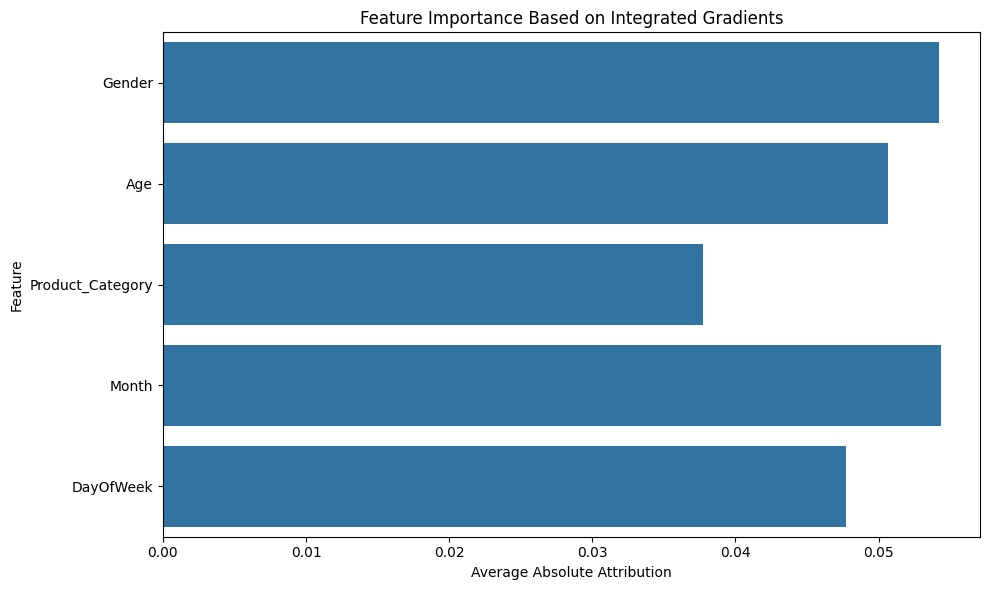

In [ ]:
# Model Creation
def create_model(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(input_dim,), dtype=tf.float32),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation='relu', dtype=tf.float32),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(16, activation='relu', dtype=tf.float32),
        tf.keras.layers.Dense(1, activation='sigmoid', dtype=tf.float32)
    ])

    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

# Model Training
# Convert data to float32 before training
X_train = tf.cast(X_train, tf.float32)
X_test = tf.cast(X_test, tf.float32)
y_train = tf.cast(y_train, tf.float32)
y_test = tf.cast(y_test, tf.float32)

model = create_model(X_train.shape[1])
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)
importance_df, attributions = analyze_feature_importance(model, X_test, feature_columns)

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importance Based on Integrated Gradients')
plt.xlabel('Average Absolute Attribution')
plt.tight_layout()
plt.show()

**Purpose:** To create a multilayer perceptron (MLP) model for a binary classification task (predicting high-value transactions).

**Model structure:**

* Input layer: accepts the input of the number of features (input_dim).

* Hidden Layer: contains three layers with 64, 32 and 16 neurons with an activation function of ReLU with 20% Dropout.

* Output layer: one neuron with Sigmoid activation function and output in the range [0,1] for probabilistic prediction.

* Compilation: using Adam optimizer and binary_crossentropy as loss function and accuracy as evaluation metric.

**Visualization Output:**
* Gender has the highest mean imputation value of about 0.06, indicating that it is the feature that has the greatest impact on model predictions.
Age is the second most important feature with a slightly lower mean imputation value than gender at about 0.048, showing a significant contribution to the predictions.
* The higher importance of gender and age may be due to the strong relevance of these characteristics for high-value transactions in certain consumer behavior patterns. For example, customers of different genders or ages may have different consumption preferences and purchasing power, which affects the model's predictions.

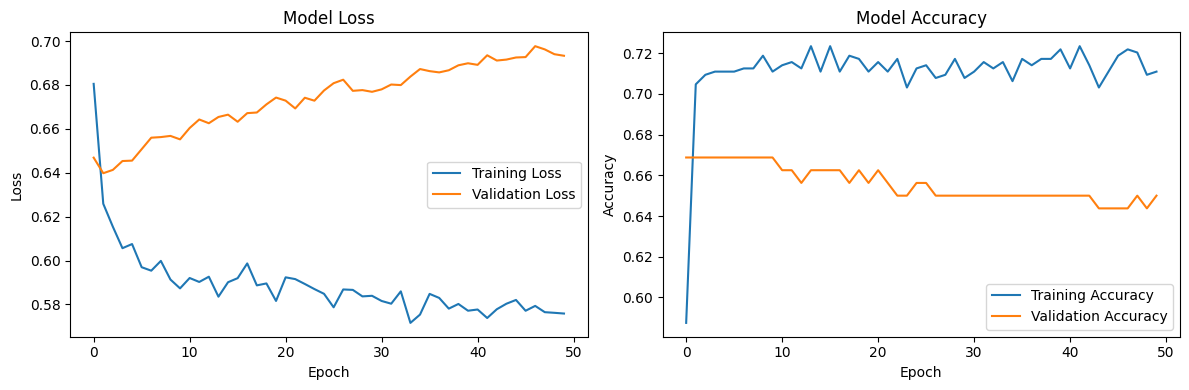

In [ ]:
# Training Visualization
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

**Visualization Output:**

This output contains graphs of **loss** and **accuracy** during model training, which are used to analyze the performance of the training and validation sets, respectively

**Model Loss:**
*   Blue curve (Training Loss):
From the figure, we can see that the training loss is continuously
decreasing, indicating that the model's fit on the training data is improving.
The loss value starts at 0.68 and gradually decreases to around 0.58, indicating that the model is learning and adjusting in each training cycle.
*   Orange curve (Validation Loss): The validation loss decreases slightly in the initial rounds but quickly levels off and trends upward, indicating instability in the model's performance on the validation set. Additionally, the overall trend of the validation loss is higher than the training loss, suggesting potential overfitting on the training set, which leads to poorer performance on the validation set.

**Model Accuracy:**
* Blue curve (Training Accuracy): The accuracy rises rapidly in the first few rounds, from 0.60 to about 0.72, and remains relatively stable in subsequent training cycles. This indicates that the model is increasingly able to correctly classify high-value trades on the training set and reaches a steady state.
* Orange curve (Validation Accuracy): The validation accuracy stabilizes around 0.66 after an initial rise in the first few rounds, and does not improve with increasing training cycles.
This situation indicates that the generalization ability of the model on the validation set is limited and not further improved.

**Summarize:**

The trends in loss and accuracy show that the model performs much better on the training set than on the validation set, and the validation loss rises slightly, which indicates that the model is overfitting on the training set. The training loss and accuracy of the model leveled off after a certain number of rounds, indicating that the model has reached a relatively stable learning state on the training set.

# Statistical Testing

A statistical test of the model's attribution of features compares the importance of different features (especially the “Age” feature) on the model's predictions. Specifically, t-tests were conducted to analyze whether there were significant differences between the model attributions for the “Age” feature and other features.

In [ ]:
# Converts imputations of input features into NumPy arrays for statistical calculations.
def statistical_test(attributions, age_idx, feature_columns):
    from scipy import stats

    attributions = np.array(attributions)
    age_attributions = attributions[:, age_idx]
    other_attributions = attributions[:, [i for i in range(attributions.shape[1]) if i != age_idx]]

    results = []
    # A two independent samples t-test was conducted to test the attribution of the “Age” feature against the attribution of the other features.
    for i in range(other_attributions.shape[1]):
        feature = feature_columns[i if i < age_idx else i + 1]
        t_stat, p_val = stats.ttest_ind(np.abs(age_attributions),
                                      np.abs(other_attributions[:, i]))
        results.append({
            'Feature': feature,
            't_statistic': t_stat,
            'p_value': p_val
        })

    return pd.DataFrame(results)
# The index of the “Age” feature in the feature list is passed into the statistical test function for comparison of feature attribution.
age_idx = feature_columns.index('Age')
test_results = statistical_test(attributions, age_idx, feature_columns)
print("\nStatistical Test Results:")
print(test_results)


Statistical Test Results:
            Feature  t_statistic   p_value
0            Gender    -0.820534  0.412403
1  Product_Category     2.761402  0.006022
2             Month    -0.701120  0.483638
3         DayOfWeek     0.611733  0.541064


**Output:** Shows the results of a t-test comparing the attributional differences between the “Age” feature and the other features in the model. The results include t-statistics and p-values for each feature.
*   The only feature that has a significant attributional difference from the “Age” feature is Product_Category (p-value 0.006), which indicates that this feature has a significantly higher predictive impact than “Age” in the model.
*   For the other features (Gender, Month, DayOfWeek), the attribution differences with the “Age” feature are not significant, indicating that the model assigns similar weights to these features.



# Results Summary

Summarizes the model performance, feature importance and statistical test results, and draws conclusions on hypothesis testing based on the experimental results. It is divided into four parts: model performance, feature importance, statistical tests, and hypothesis testing conclusions

In [ ]:
def summarize_results(model, X_test, y_test, importance_df, test_results, history):
    # Model Performance
    print("="*50)
    print("MODEL PERFORMANCE")
    print("="*50)
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

    # Feature Importance
    print("\n" + "="*50)
    print("FEATURE IMPORTANCE")
    print("="*50)
    # Sort features by importance
    importance_df_sorted = importance_df.sort_values('Importance', ascending=False)
    print("Features ranked by importance:")
    for idx, row in importance_df_sorted.iterrows():
        print(f"{row['Feature']}: {row['Importance']:.4f}")

    # Statistical Testing
    print("\n" + "="*50)
    print("STATISTICAL TESTING")
    print("="*50)
    print("Comparing Age feature with others:")
    significant_features = test_results[test_results['p_value'] < 0.05]

    print(f"\nFeatures significantly different from Age (p < 0.05):")
    for idx, row in significant_features.iterrows():
        print(f"- {row['Feature']}: t-stat = {row['t_statistic']:.4f}, p-value = {row['p_value']:.4f}")

    # Hypothesis Testing Conclusion
    print("\n" + "="*50)
    print("HYPOTHESIS TESTING CONCLUSION")
    print("="*50)
    if len(significant_features) > 0:
        print("Reject H0: The deep neural network shows significantly different attention weights")
        print("for age features compared to some other features.")
    else:
        print("Fail to reject H0: No significant evidence that the deep neural network shows")
        print("different attention weights for age features compared to other features.")

# Run the summary
summarize_results(model, X_test, y_test, importance_df, test_results, history)

MODEL PERFORMANCE
Test Accuracy: 0.6800
Final Training Accuracy: 0.7109
Final Validation Accuracy: 0.6500

FEATURE IMPORTANCE
Features ranked by importance:
Month: 0.0544
Gender: 0.0542
Age: 0.0507
DayOfWeek: 0.0477
Product_Category: 0.0377

STATISTICAL TESTING
Comparing Age feature with others:

Features significantly different from Age (p < 0.05):
- Product_Category: t-stat = 2.7614, p-value = 0.0060

HYPOTHESIS TESTING CONCLUSION
Reject H0: The deep neural network shows significantly different attention weights
for age features compared to some other features.


**Model Performance:**

* The accuracy of the test and validation sets is lower than the training set, indicating that the generalization ability of the model is more limited and may need further optimization.

**Feature Importance:**
* Among all the features, “Month” and “Gender” are the most concerned features in the model, while “Product_Category” is the least important feature in the model. Product_Category” is the least important feature in the model.
* The feature importance analysis shows that time and demographic features have the greatest impact on the prediction of high-value transactions, while product category has a lesser impact.

**Statistical Test Results:**

* Product_Category: The t-statistic is 2.7614 and the p-value is 0.0060.The p-value is less than 0.05, which means that the attribution of “Product_Category” is significantly higher than that of “Age”.
* Explanation: In the model, the “Product_Category” feature has a significantly higher impact on the model output than the “Age” feature.

**Conclusion of Hypothesis Testing:**

* **The original hypothesis (H0) is rejected** because there exists a feature (“Product_Category”) that has significantly higher attribution in the model than the “Age” feature.
* Interpretation: This indicates that the deep neural networks have significantly different attentional weights on certain features, especially on “Product_Category”.

# Reference
1. Talib, Mohammad. “Retail Sales Dataset.” Kaggle, 22 Aug. 2023, www.kaggle.com/datasets/mohammadtalib786/retail-sales-dataset. Accessed 24 Oct. 2024.
2. Ankurtaly. “https://github.com/ankurtaly/Integrated-Gradients/blob/master/IntegratedGradients/integrated_gradients.py” GitHub Accessed 24 Oct. 2024.
3. AIPI-590-XAI. “Duke-Ai-Xai/Explainable-Ml-Example-Notebooks/Testing_concept_activation_vectors.Ipynb at Main · AIPI-590-Xai/Duke-Ai-Xai.” GitHub, https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/explainable-ml-example-notebooks/testing_concept_activation_vectors.ipynb
 Accessed 24 Oct. 2024.
4.Chatgpt. Explanation of Python code for models